# ECSE 415: Final Project
Mathieu Geoffroy, 260986559
Ryan Reszetnik, 260948454


December 5th, 2023

In [137]:
import numpy as np
import cv2
import os
from ultralytics import YOLO
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

working_dir = os.path.curdir

In [138]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = YOLO('yolov8n.pt').to(device)

# import YOLO labels from the dataset
yolo_labels = model.names

In [139]:
def calc_flow(img1,img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return cv2.calcOpticalFlowFarneback(prev=img1_gray, 
                                    next=img2_gray, 
                                    flow=None,
                                    pyr_scale=0.5, 
                                    levels=3, 
                                    winsize=15,
                                    iterations=3, 
                                    poly_n=5, 
                                    poly_sigma=1.2, 
                                    flags=0)
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

In [140]:
# Open the video file
def analyze_video(video_path, display=True, save=True):
    cap = cv2.VideoCapture(video_path)
    # for i in range(30*30):
    #     cap.read()
    # get video name
    video_name = video_path.split('/')[-1].split('.')[0]
    
    out = cv2.VideoWriter(f'{video_name}_analyzed.mp4',cv2.VideoWriter_fourcc('m','p','4','v'), 30, (int(cap.get(3)),int(cap.get(4))))
    
    # Store the track history
    track_history = defaultdict(lambda: [])
    
    people_count = 0
    car_count = 0
    max_speed = 0
    
    # Loop through the video frames

    frame_count = 0
    # prev_frame = cap.read()[1]

    object_positions = {}


    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()
        # flow = calc_flow(prev_frame, frame)
        # print(flow.shape)
        frame_count += 1
        # if frame_count == 90:
        #     success = False
        print("frame count", frame_count)
        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            #change the timeout to 0.5 for NMS
            results = model.track(frame, persist=True)
    
            # Get the boxes, masks, track IDs, class, for the frame
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            classes = results[0].boxes.cls.int().cpu().tolist()
    
            # Visualize the results on the frame
            annotated_frame = results[0].plot()
            
            # calculate the number of new people and cars
            for cls, track_id in zip(classes, track_ids):
                if yolo_labels[cls] == 'person' and track_id not in track_history:
                    people_count += 1
                if yolo_labels[cls] == 'car' and track_id not in track_history:
                    car_count += 1
                # calculate the speed by tracking stationary objects
                if yolo_labels[cls] == 'traffic light' or yolo_labels[cls] == 'stop sign' or yolo_labels[cls] == 'fire hydrant':
                    if len(track_history[track_id]) > 1:
                        last_point = track_history[track_id][-1]
                        second_last_point = track_history[track_id][-2]
                        distance = np.sqrt((last_point[0] - second_last_point[0])**2 + (last_point[1] - second_last_point[1])**2)
                        # convert pixels to meters
                        distance = distance * 0.0002645833
                        
                        # calculate speed in km/h
                        speed = distance * 3600
                        
                        max_speed = max(max_speed, speed)
                    
            
            # Display the number of people
            cv2.putText(annotated_frame, f"Number of people: {people_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the number of cars
            cv2.putText(annotated_frame, f"Number of cars: {car_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the speed
            cv2.putText(annotated_frame, f"Speed: {max_speed} km/h", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)     
    
            # Plot the tracks
            for box,track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)
                #draw the mask on the frame as a red polygon
                if(object_positions.get(track_id) == None):
                    object_positions[track_id] = []
                object_positions[track_id].append((x,y))

               
                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)
    
            # Display the annotated frame
            # cv2.imshow(f'{video_name} Tracking', annotated_frame) if display else None
            # plt.imshow(annotated_frame)
            # flow_img = draw_flow(frame, flow)
          
            # plt.show()
            # plt.imshow(flow_img)
            # plt.show()
            # save the annotated frame to a new video
            out.write(annotated_frame) if save else None
    
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break
    
    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()

    return people_count, car_count, max_speed,object_positions 

In [141]:
people_count, car_count, max_speed,object_positions =analyze_video(working_dir + '/mcgill_drive.mp4', display=False, save=True)
# print(analyze_video(working_dir + '/st-catherines_drive.mp4', display=False, save=True))

frame count 1

0: 384x640 3 cars, 102.8ms
Speed: 18.1ms preprocess, 102.8ms inference, 82.9ms postprocess per image at shape (1, 3, 384, 640)
frame count 2

0: 384x640 3 cars, 48.7ms
Speed: 20.3ms preprocess, 48.7ms inference, 189.4ms postprocess per image at shape (1, 3, 384, 640)
frame count 3

0: 384x640 5 cars, 24.1ms
Speed: 5.5ms preprocess, 24.1ms inference, 30.6ms postprocess per image at shape (1, 3, 384, 640)
frame count 4

0: 384x640 5 cars, 24.2ms
Speed: 4.2ms preprocess, 24.2ms inference, 29.2ms postprocess per image at shape (1, 3, 384, 640)
frame count 5

0: 384x640 5 cars, 25.4ms
Speed: 2.9ms preprocess, 25.4ms inference, 31.4ms postprocess per image at shape (1, 3, 384, 640)
frame count 6

0: 384x640 5 cars, 34.6ms
Speed: 2.8ms preprocess, 34.6ms inference, 61.8ms postprocess per image at shape (1, 3, 384, 640)
frame count 7

0: 384x640 5 cars, 37.9ms
Speed: 2.6ms preprocess, 37.9ms inference, 19.8ms postprocess per image at shape (1, 3, 384, 640)
frame count 8

0: 384x

[        nan      1.0418      2.0729      2.1098      1.3388      2.0359       2.021      1.5358      2.1378      1.7904      1.5953      1.7756      1.4027      2.2958      2.3372      2.5841      1.8665      1.5799     0.96089      2.1753      2.4132         nan      2.8785      3.3797      3.1108      1.2962] [    0.18667      0.5232     0.74384     0.68136     0.75119     0.74017       0.951     0.92449     0.76665     0.72769     0.76142      1.1369     0.72317     0.95854     0.89762     0.59096]


/var/folders/6p/607f1c2n2dz6fdrqvw9q_hlr0000gn/T/ipykernel_91487/277815275.py:11: RuntimeWarning: invalid value encountered in power
  new_pos = new_pos**1.5


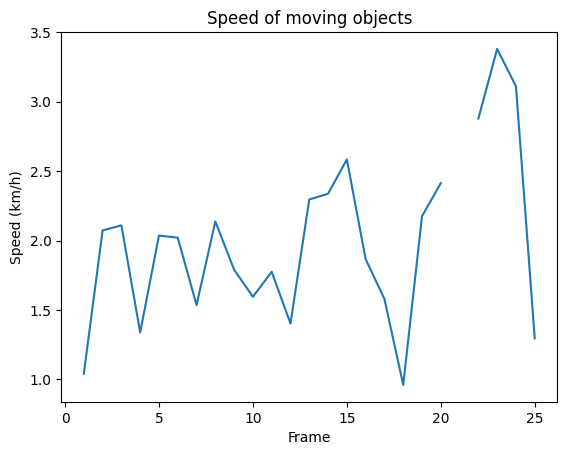

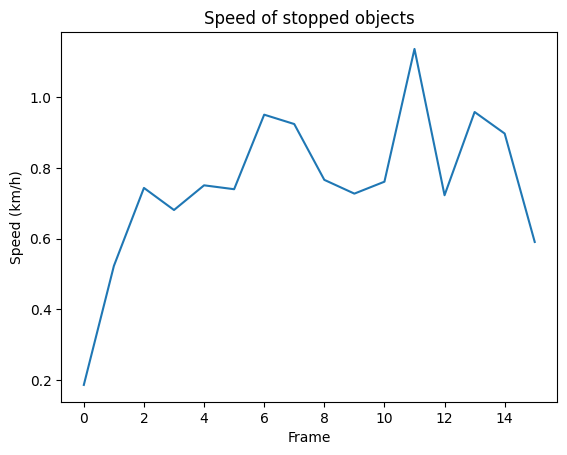

In [171]:


def get_actual_speed(positions):
    new_pos = []
    for i in range(len(positions)):
        new_pos.append((positions[i][0].numpy(),positions[i][1].numpy()))
    new_pos = np.array(new_pos)
    speed = []
    for j in range(len(new_pos)-1):
        speed.append(np.sqrt((new_pos[j][0]-new_pos[j+1][0])**2+(new_pos[j][1]-new_pos[j+1][1])**2))
    speed = np.array(speed)
    new_pos = 1220-new_pos[:-1,0]
    new_pos = new_pos**1.5
    speed = speed/new_pos * 1000
    return speed

moving_ids = [
    3,5,6,7,10,11,19,30,31,42,45,46,50,63,64,69,75,94,106,119,121,122,135,141,147,149
]
stopped_ids = [
    1,2,25,83,87,91,92,95,109,112,133,150,153,155,156,154
]

moving_speeds = [np.mean(np.array(get_actual_speed(object_positions[i]))) for i in moving_ids]
stopped_speeds = [np.mean(np.array(get_actual_speed(object_positions[i]))) for i in stopped_ids]

#get average speed of moving objects
moving_speeds = np.array(moving_speeds)
#get average speed of stopped objects
stopped_speeds = np.array(stopped_speeds)

print(moving_speeds,stopped_speeds)

#plot the speed of moving objects
plt.plot(moving_speeds)
plt.title("Speed of moving objects")
plt.xlabel("Frame")
plt.ylabel("Speed (km/h)")
plt.show()

#plot the speed of stopped objects
plt.plot(stopped_speeds)
plt.title("Speed of stopped objects")
plt.xlabel("Frame")
plt.ylabel("Speed (km/h)")
plt.show()



